# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [ ]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

--2024-12-08 16:21:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [      <=>           ]  58.17M  53.2MB/s    in 1.1s    

2024-12-08 16:21:41 (53.2 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]

Archive:  UCI HAR Dataset.zip
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: UCI HAR Dataset/test/X_test.txt  
  inflating: UCI HAR Dataset/test/y_test.txt  
  inflating: UCI HAR Dataset/train/X_train.txt  
  inflating: UCI HAR Dataset/train/y_train.txt  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [ ]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [ ]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [ ]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [ ]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

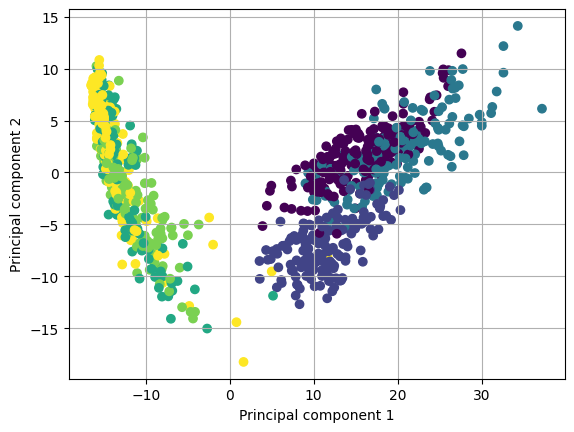

In [ ]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

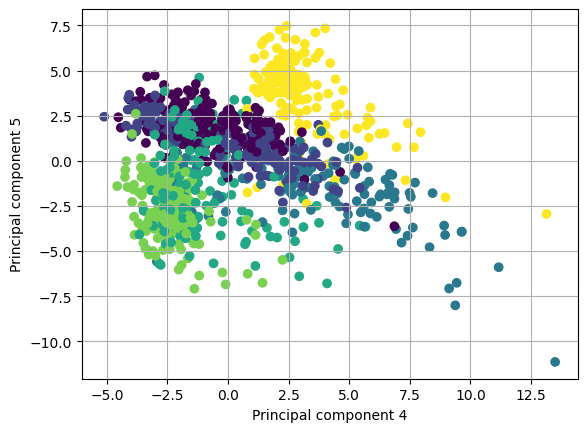

In [ ]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

In [ ]:
!pip install ucimlrepo

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

In [ ]:
import ucimlrepo as uci

In [ ]:
dataset = uci.fetch_ucirepo(id=186)

print(dataset.metadata.name, '\n')
print(dataset.metadata.abstract, '\n')
print(dataset.metadata.additional_info.summary, '\n')

Wine Quality 

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/). 

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to t

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [ ]:
# YOUR CODE HERE

# Example: https://rpubs.com/burakh/har_xgb

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier


model = CatBoostClassifier(silent=True)
param_grid = {
    'iterations': [3, 5, 7],
    'depth': [2, 4, 8],
    'learning_rate': [0.1, 0.5, 1],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [4, 8, 16]
}

# Инициализируйте GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Обучите модель
grid_search.fit(X_train_pca, y_train)

# Получите лучшие гиперпараметры
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Лучшие гиперпараметры: {best_params}")
print(f"Лучший кросс-валидационный балл: {best_score}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие гиперпараметры: {'border_count': 16, 'depth': 8, 'iterations': 7, 'l2_leaf_reg': 3, 'learning_rate': 0.5}
Лучший кросс-валидационный балл: 0.7927111244334535


## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/) or [hyperopt](http://hyperopt.github.io/hyperopt/) zero order optimizer to find optimal hyper param set.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
# YOUR CODE HERE

import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split


def objective(trial):
    # Define hyperparameters to tune
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 5),
        'border_count': trial.suggest_int('border_count', 32, 100),
        'silent': True
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)

    # Return the accuracy
    return model.score(X_test, y_test)

# Create a study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters and score
print(f"Best hyperparameters: {study.best_params}")
print(f"Best score: {study.best_value}")


[I 2024-12-08 17:01:31,129] A new study created in memory with name: no-name-65f8d540-12aa-4e10-a319-26a08329b4be
<ipython-input-21-7c409bcea173>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
[I 2024-12-08 17:01:52,488] Trial 0 finished with value: 0.9202578893790295 and parameters: {'iterations': 128, 'depth': 4, 'learning_rate': 0.2772577457905408, 'l2_leaf_reg': 1, 'border_count': 100}. Best is trial 0 with value: 0.9202578893790295.
[I 2024-12-08 17:02:39,993] Trial 1 finished with value: 0.9331523583305056 and parameters: {'iterations': 228, 'depth': 5, 'learning_rate': 0.19329856039582377, 'l2_leaf_reg': 2, 'border_count': 75}. Best is trial 1 with value: 0.9331523583305056.
[I 2024-12-08 17:03:32,153] Trial 2 finished with value: 0.894129623345775

Best hyperparameters: {'iterations': 272, 'depth': 4, 'learning_rate': 0.23262124208754142, 'l2_leaf_reg': 3, 'border_count': 89}
Best score: 0.9379029521547336


### Conclusion

Please, write down your thoughts on the experiment results:


####Итерации: Лучший эксперимент использовал 272 итерации, что говорит о том, что достаточное количество итераций позволяет модели лучше захватывать сложные паттерны в данных.
####Глубина: Глубина 4 оказалась наиболее эффективной, что может указывать на оптимальное соотношение между сложностью модели и ее способностью к обобщению.
####Скорость обучения: Оптимальная скорость обучения 0.2326 показывает, что умеренные значения способствуют лучшей производительности, в то время как слишком низкие или высокие значения могут привести к ухудшению результатов.
####Регуляризация L2: Значение 3 для регуляризации помогает предотвратить переобучение, что особенно важно при работе с более сложными моделями.
####Количество границ: Значение 89 для количества границ может быть связано с эффективным разделением данных на классы.




Наблюдается тенденция, что увеличение числа итераций и использование глубины 4 с умеренной скоростью обучения приводят к лучшим результатам.
Некоторые комбинации гиперпараметров, такие как высокая скорость обучения или слишком большая глубина, приводили к ухудшению производительности.


## Part 3. Interpret the model predictions

Train model on original feature set and analyze it.

Please use [shap](https://github.com/slundberg/shap) to build beeswarm plot and at least one of your choice and interpret them (write conclusion).

Explanations of features can be found on dataset's UCI page (see dataset downloading section).

In [ ]:
!pip install shap

In [ ]:
import shap  # noqa: F401


# YOUR CODE HERE

import numpy as np
import pandas as pd
import shap
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Train the CatBoost model on the original feature set
model = CatBoostClassifier(iterations=272, depth=4, learning_rate=0.23262124208754142, l2_leaf_reg=3, border_count=89, silent=True)
model.fit(X_train, y_train)




In [ ]:
# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

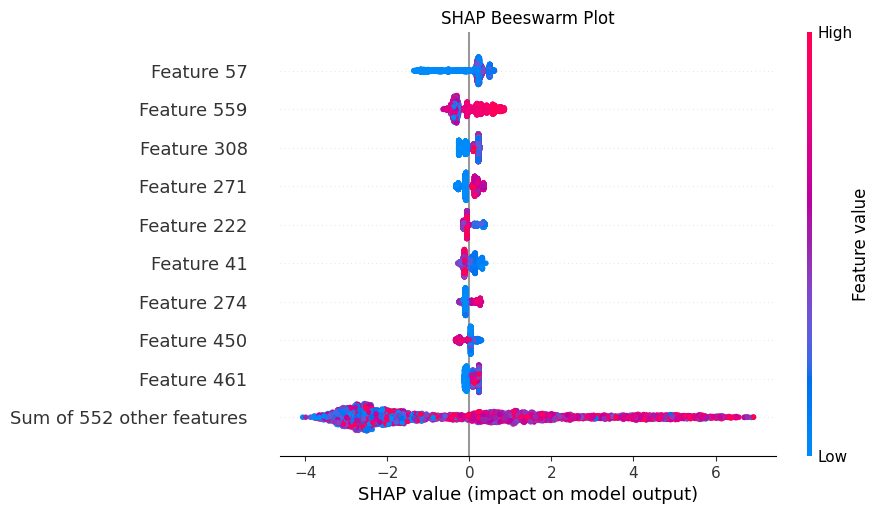

In [ ]:
# Beeswarm plot
plt.figure(figsize=(10, 6))
plt.title("SHAP Beeswarm Plot")
shap.plots.beeswarm(shap_values[:, :, 1])

plt.show()

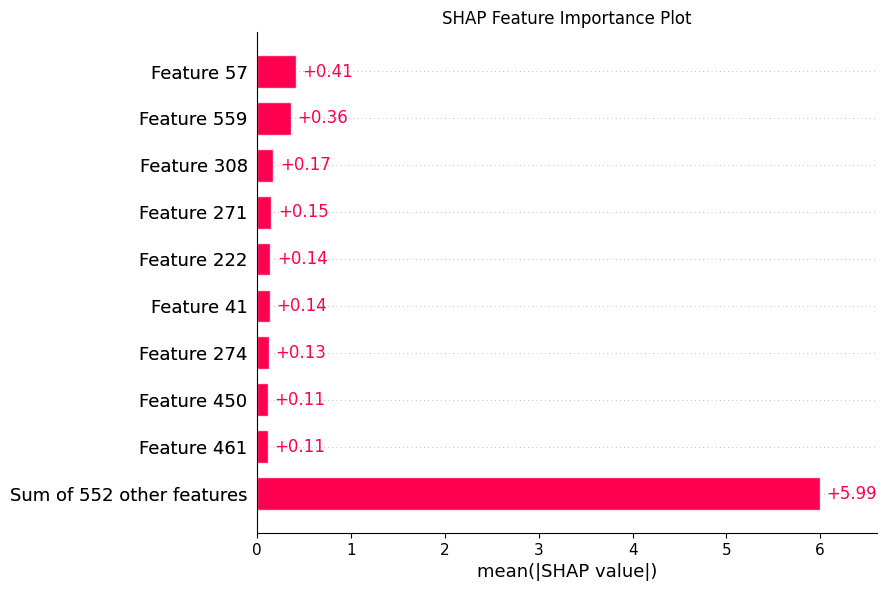

In [ ]:


# Feature importance plot
plt.figure(figsize=(10, 6))
plt.title("SHAP Feature Importance Plot")
shap.plots.bar(shap_values[:, :, 1])

plt.show()

### Conclusion

Your thoughts about the plots and model behaviour:

График Beeswarm: Этот график показывает распределение значений SHAP для каждого признака по всем образцам. Каждая точка представляет значение SHAP для признака и образца, указывая, насколько этот признак способствовал прогнозу. Признаки с более широкими распределениями или более экстремальными значениями оказывают большее влияние на прогнозы модели.

График важности признаков: Этот столбчатый график ранжирует признаки на основе их средних абсолютных значений SHAP. Более высокие столбцы указывают на более важные признаки. Это помогает определить, какие признаки наиболее сильно влияют на прогнозы модели.